In [36]:
import numpy as np
from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import FDEM, TDEM, mu_0
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver as Solver
%matplotlib inline

# set a nice colormap
plt.set_cmap(plt.get_cmap('viridis'))

# Model Parameters

In [2]:
sigmaair = 1e-8  # air
sigmaback = 1e-2  # background

sigmacasing = 5.5e6  # casing
sigmainside = 1  # inside the casing
mucasing = 50  # casing permeability

casing_l = 1000   # length of the casing
casing_d = 10e-2  # 10cm diameter casing
casing_t = 1e-2   # 1cm thickness

# layer
sigmalayer = sigmaback
layer_z = np.r_[-1000., -900.]

# # 3D body
# sigmablock =  2.
# block_x = np.r_[75., 475.]
# block_y = np.r_[-125, 125.]
# block_z = layer_z

# Survey Params
freqs = np.r_[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]  # frequencies 0.5
dsz = -950.  # down-hole z source location

src_a = np.r_[0., 0., dsz]
src_b = np.r_[1e4, 0.,  0.]  # return electrode is a ring, 200

In [3]:
# useful quantities to work in
casing_r = casing_d/2.
casing_a = casing_r - casing_t/2.  # inner radius
casing_b = casing_r + casing_t/2.  # outer radius
casing_z = np.r_[-casing_l, 0.]

In [27]:
# -------------- Mesh Parameters ------------------ #
# x-direction
csx1, csx2 = 2.5e-3, 25.  # fine cells near well bore
pfx1, pfx2 = 1.3, 1.5  # padding factors: fine -> uniform
ncx1 = np.ceil(casing_b/csx1+2)  # number of fine cells
                                      # (past casing wall)
dx2 = 1000.  # uniform mesh out to here
npadx2 = 23  # padding out to infinity

# z-direction
csz = 0.05  # finest z-cells
nza = 10  # number of fine cells above air-earth interface
pfz = pfx2 # padding factor in z-direction

# ------------- Assemble the Cyl Mesh ------------- #
# pad nicely to second cell size
npadx1 = np.floor(np.log(csx2/csx1) / np.log(pfx1))
hx1a = Utils.meshTensor([(csx1, ncx1)])
hx1b = Utils.meshTensor([(csx1, npadx1, pfx1)])
dx1 = sum(hx1a)+sum(hx1b)
dx1 = np.floor(dx1/csx2)
hx1b *= (dx1*csx2 - sum(hx1a))/sum(hx1b)

# second chunk of mesh
ncx2 = np.ceil((dx2 - dx1)/csx2)
hx2a = Utils.meshTensor([(csx2, ncx2)])
hx2b = Utils.meshTensor([(csx2, npadx2, pfx2)])
hx = np.hstack([hx1a, hx1b, hx2a, hx2b])

# cell size, number of core cells, number of padding cells in the
# x-direction
ncz = np.int(np.ceil(np.diff(casing_z)[0]/csz))+10
npadzu, npadzd = 38, 38

# vector of cell widths in the z-direction
hz = Utils.meshTensor(
        [(csz, npadzd, -pfz), (csz, ncz), (csz, npadzu, pfz)]
        )

# primary mesh
mesh = Mesh.CylMesh(
    [hx, 1., hz], [0., 0., -np.sum(hz[:npadzu+ncz-nza])]
    )

print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(sigmaback*f) for f in freqs])
print([500./np.sqrt(sigmacasing*f) for f in freqs])

Cyl Mesh Extent xmax: 702446.341501,: zmin: -615296.090052, zmax: 614296.590053
2450492
[500000.0, 158113.88300841895, 50000.0, 15811.388300841898, 7071.0678118654751, 5000.0]
[21.320071635561042, 6.7419986246324211, 2.1320071635561044, 0.67419986246324204, 0.30151134457776363, 0.21320071635561044]


# plot model

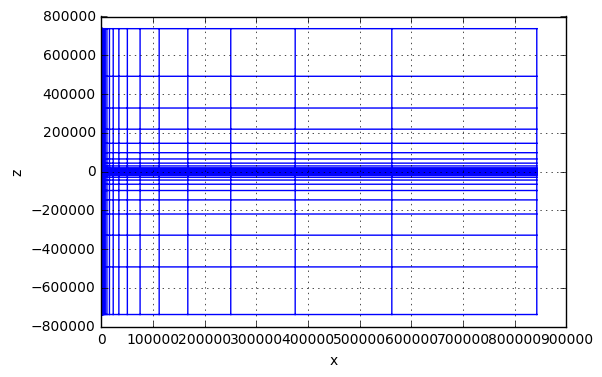

In [7]:
mesh.plotGrid()

In [74]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

sigma_m = np.r_[
    np.log(sigmaback), np.log(sigmalayer), np.log(sigmacasing), np.log(sigmainside),
    layer_z.mean(), layer_z[1] - layer_z[0], casing_r, casing_t, 
    casing_z[0], casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, mucasing*mu_0, mu_0,
    layer_z.mean(), layer_z[1] - layer_z[0], casing_r, casing_t, 
    casing_z[0], casing_z[1]
]

In [75]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 23 s, sys: 523 ms, total: 23.6 s
Wall time: 24.2 s


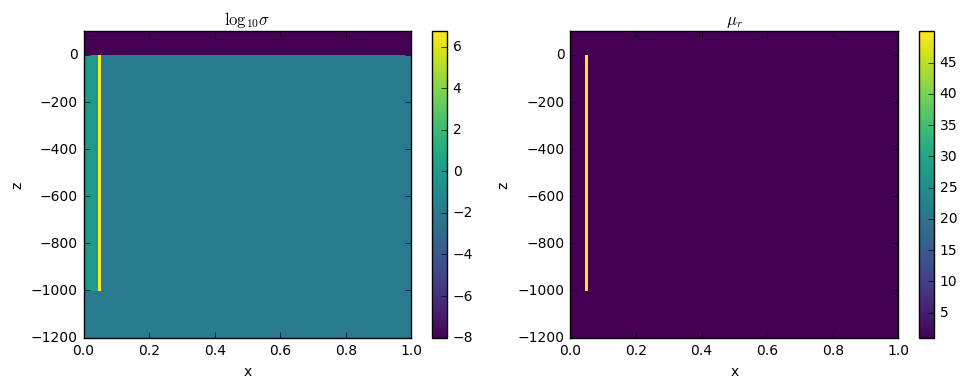

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

xlim = [0., 1.]
zlim = [-1200., 100.]

plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax[0])[0], ax=ax[0])
plt.colorbar(mesh.plotImage(mu/mu_0, ax=ax[1])[0], ax=ax[1])

ax[0].set_xlim(xlim)
ax[1].set_xlim(xlim)

ax[0].set_ylim(zlim)
ax[1].set_ylim(zlim)

ax[0].set_title('$\log_{10}\sigma$')
ax[1].set_title('$\mu_r$')

plt.tight_layout()

In [66]:
sigma.max()

5481340.7180621233